Fine-art Classification - Tom Douven

Following sources were used for coding:

-https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
-https://www.kaggle.com/code/archisha26/imagedatagenerator-efficientnet-b0/notebook

In [1]:
#import Packages|
from google.colab import drive
from os import remove
import pandas as pd
import os
import tensorflow as tf
from typing import List, Dict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from typing import Iterator, List, Union, Tuple
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import glob
import pathlib
import itertools
import requests
import seaborn as sns
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from struct import unpack
from keras import Sequential
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix,classification_report
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import model_from_json
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB5

In [5]:
#Directory to dataset in drive
drive.mount('/content/gdrive', force_remount=True)
data_path = '/content/gdrive/MyDrive/Thesis/wikiart/'

Mounted at /content/gdrive


In [ ]:
#Select TPU or GPU/CPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Artist classification with EfficientNet B0 example

PREPARING DATA SAMPLES

In [ ]:
#Load in metadata as dataframe
traindf = pd.read_csv("/content/gdrive/MyDrive/Thesis/wikiart_csv/artist_train.csv" ,header=None, dtype=str)
testdf = pd.read_csv("/content/gdrive/MyDrive/Thesis/wikiart_csv/artist_val.csv",header=None, dtype=str)

#Shuffeling the data 
traindf = traindf.sample(frac=1)
testdf = testdf.sample(frac=1)

traindf.rename(columns = {0:'img_path', 1:'label'}, inplace = True)
testdf.rename(columns = {0:'img_path', 1:'label'}, inplace = True)
completedf = pd.concat([traindf, testdf])

df_x = completedf['img_path']
df_y = completedf['label']

#Split full sample into Train and Test
#Create proportional splits for test and validation
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                stratify= df_y, 
                                                test_size=(0.3))

dftrain = {'img_path': x_train, 'label': y_train}
dftrain = pd.DataFrame(dftrain)
dftest = {'img_path': x_test, 'label': y_test}
dftest = pd.DataFrame(dftest)

#Split test into Val and Test
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,
                                                stratify= y_test, 
                                                test_size=(1/3))

dfval = {'img_path': x_val, 'label': y_val}
dfval = pd.DataFrame(dfval)
dftest = {'img_path': x_test, 'label': y_test}
dftest = pd.DataFrame(dftest)

In [ ]:
#Check proportions
print('length full dataset:', len(completedf))
print()
print("lentgth x train:", len(x_train))
print("lentgth y train:", len(y_train))
print()
print("lentgth x val:", len(x_val))
print("lentgth y val:", len(y_val))
print()
print("lentgth x test:", len(x_test))
print("lentgth y test:", len(y_test))

length full dataset: 19052

lentgth x train: 13336
lentgth y train: 13336

lentgth x val: 1906
lentgth y val: 1906

lentgth x test: 3810
lentgth y test: 3810


In [ ]:
#Create label weights for unbalanced classes
artist_dict = {}

for x in completedf['label']:
    if x in artist_dict:
        artist_dict[x] += 1
    else:
        artist_dict[x] = 1

#artist_dict = dict(sorted(artist_dict.items(), key=lambda item: item[1]))
print(artist_dict)

# compute class weight 
# based on appearance of each class in y_trian
clss_weight = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = np.unique(y_train),
                                        y = df_y                                                 
                                    )

# dict mapping
clss_weight = {i : clss_weight[i] for i, label in enumerate(sorted(np.unique(y_train)))}
print(clss_weight)

{'1': 633, '4': 1334, '14': 1819, '5': 611, '6': 555, '9': 577, '17': 1400, '13': 575, '7': 753, '2': 887, '15': 762, '22': 1890, '3': 550, '18': 919, '8': 539, '19': 516, '10': 520, '21': 479, '20': 777, '12': 765, '16': 579, '11': 784, '0': 828}
{0: 1.0004200798151648, 1: 1.3086063603269456, 2: 1.5929765886287626, 3: 1.0565661047027506, 4: 1.0828076157999431, 5: 1.4406049149338374, 6: 0.4553863804766116, 7: 1.0870706379093917, 8: 1.4306525493729818, 9: 0.5916770186335404, 10: 0.9013578085821072, 11: 1.605325244354567, 12: 0.9338757904024313, 13: 1.0660847182586313, 14: 1.7293274031042933, 15: 0.43827927306188175, 16: 1.5060869565217392, 17: 0.6209503943680333, 18: 1.3557247562797978, 19: 1.4925186055620838, 20: 1.1000635140597033, 21: 1.5368234250221828, 22: 1.435611483686233}


In [ ]:
#Set directories to access paintings with different input sizes corresponding to chosen model
dataB0_path = '/content/gdrive/MyDrive/Thesis/processed_imagesB0/'
dataB3_path = '/content/gdrive/MyDrive/Thesis/processed_imagesB3/'
dataB5_path = '/content/gdrive/MyDrive/Thesis/processed_imagesB5/'

PREPROCESSING DATA

In [ ]:
# Defining Parameters
IMAGE_SIZE = 224
EPOCHS = 25
SEED = 10
CLASSES = 23
BATCH_SIZE = 50

In [ ]:
#Create ImageDataGenerator for with augmentations for train data
train_datagen = ImageDataGenerator(horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        fill_mode="nearest")

val_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

In [ ]:
#train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dftrain,
    directory=dataB0_path,
    x_col="img_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed= 10
)

#val generator
valid_generator = val_datagen.flow_from_dataframe(
    dataframe=dfval,
    directory=dataB0_path,
    x_col="img_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed= 10
)

#test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dftest,
    directory=dataB0_path,
    x_col="img_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed= 10
)

Found 13336 validated image filenames belonging to 23 classes.
Found 1906 validated image filenames belonging to 23 classes.
Found 3810 validated image filenames belonging to 23 classes.


CREATING MODEL

In [ ]:
#Defining the model
model_B0 = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),classes=CLASSES)
model_B0.trainable = False

#Adding the final layers to the above base models where the actual classification is done in the dense layers
dropout_rate = 0.2
model = models.Sequential()
model.add(model_B0)
model.add(layers.GlobalAveragePooling2D(name="gap"))
model.add(Dense(1024,activation=('relu')))
model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
    model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(CLASSES, activation="softmax", name="fc_out"))

#Loading previous weights
#model.load('path/to/weights.hf5')

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout_out (Dropout)       (None, 1024)              0         
                                                                 
 fc1 (Dense)                 (None, 256)               26

In [ ]:
#EARLY STOPPING CALLBACK, AND SAVING EPOCH PROCESS
#https://stackoverflow.com/questions/36356004/is-it-possible-to-continue-training-from-a-specific-epoch

weight_save_callback = ModelCheckpoint('/content/gdrive/MyDrive/Thesis/Results/Weights/B0/Genre/B0Genre.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, mode='auto')

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min'),
    weight_save_callback
]

#set optimizer
optimizer = keras.optimizers.Adam()

#Compiling the model
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Training the model
history = model.fit(   
    train_generator,
    epochs = EPOCHS,
    shuffle = True, 
    steps_per_epoch = train_generator.samples//BATCH_SIZE, 
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples//BATCH_SIZE,  
    verbose = 1,
    callbacks = my_callbacks,
    class_weight= clss_weight)


#Save model
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/EfficientNetB0Artist.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/EfficientNetB0Artist.h5")
print("Saved model to disk")

Epoch 1/25
266/266 [==============================] - 4084s 15s/step - loss: 1.5689 - accuracy: 0.5222 - val_loss: 1.2462 - val_accuracy: 0.6179
Epoch 2/25
266/266 [==============================] - 149s 560ms/step - loss: 1.0736 - accuracy: 0.6678 - val_loss: 1.1148 - val_accuracy: 0.6658
Epoch 3/25
266/266 [==============================] - 149s 560ms/step - loss: 0.8842 - accuracy: 0.7146 - val_loss: 1.0755 - val_accuracy: 0.6768
Epoch 4/25
266/266 [==============================] - 149s 558ms/step - loss: 0.7450 - accuracy: 0.7580 - val_loss: 1.0164 - val_accuracy: 0.7058
Epoch 5/25
266/266 [==============================] - 149s 559ms/step - loss: 0.6458 - accuracy: 0.7808 - val_loss: 1.0477 - val_accuracy: 0.7042
Epoch 6/25
266/266 [==============================] - 149s 560ms/step - loss: 0.5764 - accuracy: 0.8047 - val_loss: 1.0137 - val_accuracy: 0.7137
Epoch 7/25
266/266 [==============================] - 149s 559ms/step - loss: 0.4981 - accuracy: 0.8267 - val_loss: 1.0259 - 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Thesis/Results/EfficientNetB3/Style/EfficientNetB3Style.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/Thesis/Results/EfficientNetB3/Style/EfficientNetB3Style.h5")
print("Saved model to disk")
 

Saved model to disk


Analyze model

In [ ]:
#Loss and Accuracy test
test_score = model.evaluate(test_generator, batch_size=BATCH_SIZE)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

77/77 [==============================] - 978s 13s/step - loss: 1.2210 - accuracy: 0.7239
[INFO] accuracy: 72.39%
[INFO] Loss:  1.2209529876708984


In [6]:
#Loading in earlier trained models
json_file = open('/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/EfficientNetB0Artist.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/EfficientNetB0Artist.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
#Display of the accuracy and the loss values
plt.figure(0)
plt.plot(model.history.history['accuracy'], label='training accuracy')
plt.plot(model.history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
#plt.savefig('/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/Accuracy-NIEUW.jpg')

plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig('/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/loss-NIEUW.jpg')

In [ ]:
#Create confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

#Transform list to string
def listToString(s):
    str1 = "" 
    for ele in s: 
        str1 += ele  
    return str1 

string_target_names = listToString(target_names)

#Give class codes the right name

#class_dictionary = {'0': 'abstract_painting', '1' : 'cityscape', '2': 'genre_painting', '3' : 'illustration', '4': 'landscape', '5': 'nude_painting', '6': 'portrait', '7': 'religious_painting', '8' :'sketch_and_study', '9': 'still_life'}
#class_dictionary = {'0': 'Abstract_Expressionism', '1' : 'Action_painting', '2': 'Analytical_Cubism', '3' : 'Art_Nouveau', '4': 'Baroque', '5': 'Color_Field_Painting', '6': 'Contemporary_Realism', '7': 'Cubism', '8' :'Early_Renaissance', '9': 'Expressionism', '10': 'Fauvism', '11' :'High_Renaissance', '12' :'Impressionism', '13' :'Mannerism_Late_Renaissance', '14': 'Minimalism', '15' :'Naive_Art_Primitivism', '16' :'New_Realism', '17': 'Northern_Renaissance', '18': 'Pointillism', '19' :'Pop_Art', '20': 'Post_Impressionism', '21' :'Realism', '22': 'Rococo', '23': 'Romanticism', '24': 'Symbolism', '25' :'Synthetic_Cubism', "26" : "Ukiyo_e"}
class_dictionary = {'0': 'Albrecht_Durer', '1' : 'Boris_Kustodiev', '2': 'Camille_Pissarro', '3' : 'Childe_Hassam', '4': 'Claude_Monet', '5': 'Edgar_Degas', '6': 'Eugene_Boudin', '7': 'Gustave_Dore', '8' :'Ilya_Repin', '9': 'Ivan_Aivazovsky', '10': 'Ivan_Shishkin', '11' :'John_Singer_Sargent', '12' :'Marc_Chagall', '13' :'Martiros_Saryan', '14': 'Nicholas_Roerich', '15' :'Pablo_Picasso', '16' :'Paul_Cezanne', '17': 'Pierre_Auguste_Renoir', '18': 'Pyotr_Konchalovsky', '19' :'Raphael_Kirchner', '20': 'Rembrandt', '21' :'Salvador_Dali', '22': 'Vincent_van_Gogh'}

class_names_list=[]
for i in target_names:
  name = class_dictionary.get(i)
  class_names_list.append(name)
  
#print(type(dictionary))
print(len(class_names_list))

#Confusion Matrix 
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

23


Confusion Matrix
Confusion matrix, without normalization


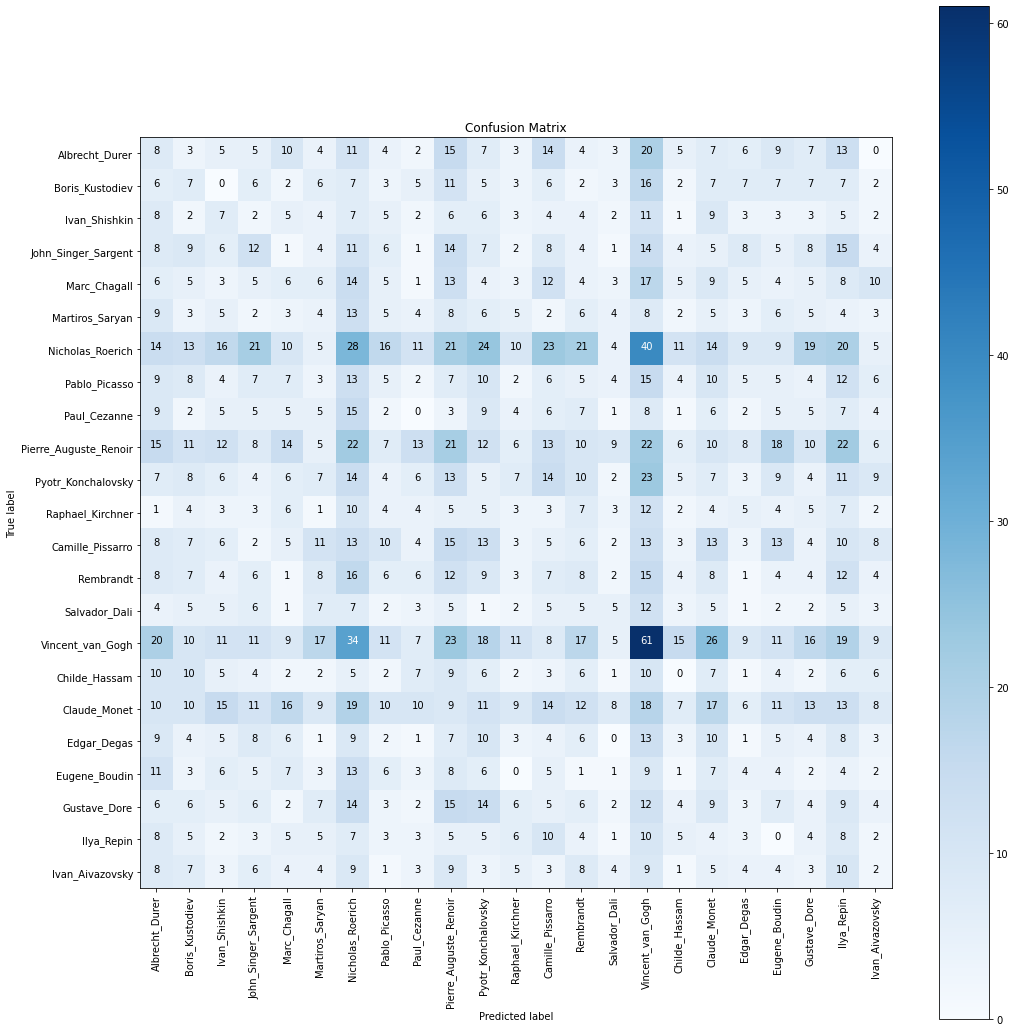

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, class_names_list, title='Confusion Matrix', normalize=False)
plt.savefig('/content/gdrive/MyDrive/Thesis/Results/EfficientNetB0/Artist/confusion-Nieuw.jpg')